# One step multivariate model

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next step ahead (time *t+1*) in the time series. This model uses recent values of temperature, as well as load, as the model input.
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load and temperature data.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

Load the data from csv into a Pandas dataframe

In [2]:
data_dir = 'data/'
energy = load_data(data_dir)
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


## Create train, validation and test sets

We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

We will allocate the period 1st November 2014 to 31st December 2014 to the test set. The period 1st September 2014 to 31st October is allocated to validation set. All other time periods are available for the training set.

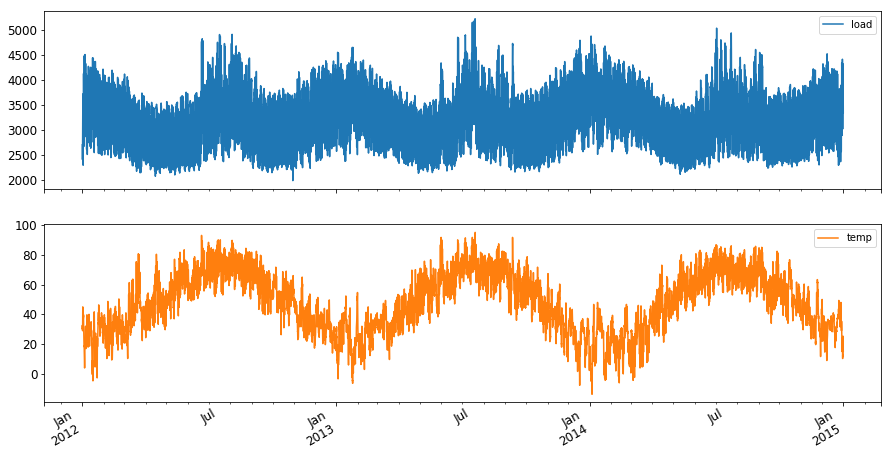

In [3]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

energy.plot(y=['load', 'temp'], subplots=True, figsize=(15, 8), fontsize=12)
plt.show()

Load and temperature in first week of July 2014

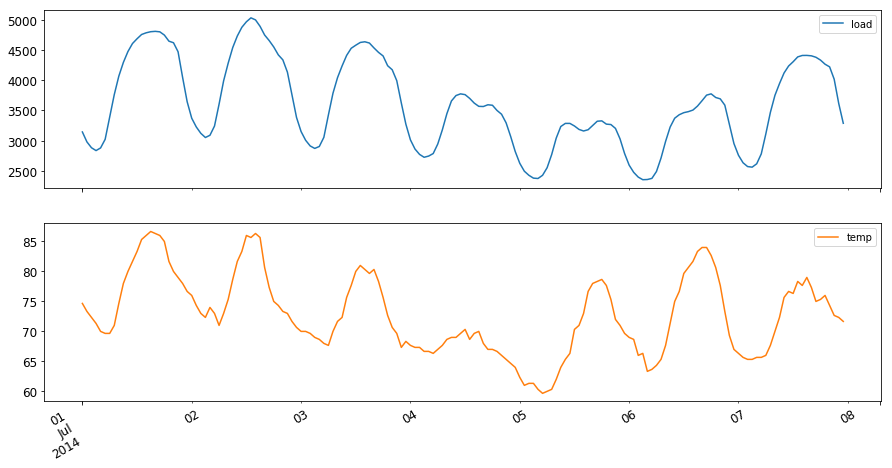

In [4]:
energy['2014-07-01':'2014-07-07'].plot(y=['load', 'temp'], subplots=True, figsize=(15, 8), fontsize=12)
plt.show()

## Data preparation

For this example, we will set *T=6*. This means that the input for each sample is a vector of the prevous 6 hours of the energy load. The choice of *T=6* was arbitrary but should be selected through experimentation.

*HORIZON=1* specifies that we have a forecasting horizon of 1 (*t+1*)

In [5]:
T = 6
HORIZON = 1

### Data preparation - training set

In [6]:
# Create training dataset with load and temp features
train = energy.copy()[energy.index < valid_start_dt][['load', 'temp']]

# Fit a scaler for the y values
y_scaler = MinMaxScaler()
y_scaler.fit(train[['load']])

# Also scale the input features data (load and temp values)
X_scaler = MinMaxScaler()
train[['load', 'temp']] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [7]:
tensor_structure = {'X':(range(-T+1, 1), ['load', 'temp'])}
train_inputs = TimeSeriesTensor(dataset=train,
                            target='load',
                            H=HORIZON,
                            tensor_structure=tensor_structure,
                            freq='H',
                            drop_incomplete=True)
train_inputs.dataframe.head(5)

tensor              target    X                                               \
feature                  y load                          temp                  
time step              t+1  t-5  t-4  t-3  t-2  t-1    t  t-5  t-4  t-3  t-2   
2012-01-01 05:00:00   0.18 0.22 0.18 0.14 0.13 0.13 0.15 0.42 0.43 0.40 0.41   
2012-01-01 06:00:00   0.23 0.18 0.14 0.13 0.13 0.15 0.18 0.43 0.40 0.41 0.42   
2012-01-01 07:00:00   0.29 0.14 0.13 0.13 0.15 0.18 0.23 0.40 0.41 0.42 0.41   
2012-01-01 08:00:00   0.35 0.13 0.13 0.15 0.18 0.23 0.29 0.41 0.42 0.41 0.40   
2012-01-01 09:00:00   0.37 0.13 0.15 0.18 0.23 0.29 0.35 0.42 0.41 0.40 0.39   

tensor                         
feature                        
time step            t-1    t  
2012-01-01 05:00:00 0.42 0.41  
2012-01-01 06:00:00 0.41 0.40  
2012-01-01 07:00:00 0.40 0.39  
2012-01-01 08:00:00 0.39 0.39  
2012-01-01 09:00:00 0.39 0.43

In [8]:
X_train = train_inputs['X']
y_train = train_inputs['target']

In [9]:
y_train.shape

(23370, 1)

In [10]:
y_train[:3]

array([[0.18],
       [0.23],
       [0.29]])

In [11]:
X_train.shape

(23370, 6, 2)

In [12]:
X_train[:3]

array([[[0.22, 0.42],
        [0.18, 0.43],
        [0.14, 0.4 ],
        [0.13, 0.41],
        [0.13, 0.42],
        [0.15, 0.41]],

       [[0.18, 0.43],
        [0.14, 0.4 ],
        [0.13, 0.41],
        [0.13, 0.42],
        [0.15, 0.41],
        [0.18, 0.4 ]],

       [[0.14, 0.4 ],
        [0.13, 0.41],
        [0.13, 0.42],
        [0.15, 0.41],
        [0.18, 0.4 ],
        [0.23, 0.39]]])

#### Data preparation - validation set

In [13]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load', 'temp']]
valid[['load', 'temp']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)
y_valid = valid_inputs['target']
X_valid = valid_inputs['X']

In [14]:
y_valid.shape

(1463, 1)

In [15]:
X_valid.shape

(1463, 6, 2)

## Quiz: Implement multivariate RNN

In [ ]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

#### Fill in your code below and replace the question mark

Implement your RNN model with the data prepared above and the following requirements:
1. Use 2 features: past load and temperature
2. Stack 2 GRU layers
3. 6 hidden units in the first GRU layer
4. 4 hidden units in the second GRU layer
5. 5 epochs
6. Batch size 32

In [ ]:
FIRST_LAYER_LATENT_DIM = ? # number of units in the 1st RNN layer
SECOND_LAYER_LATENT_DIM = ? #number of units in the 2nd RNN layer
BATCH_SIZE = ? # number of samples per mini-batch
EPOCHS = ? # maximum number of times the training algorithm will cycle through all samples

In [ ]:
# Fill in your code to replace the question mark
# Hint: there is a parameter you need to add when stacking multiple RNN layers
model = Sequential()
?
?
model.add(Dense(HORIZON))

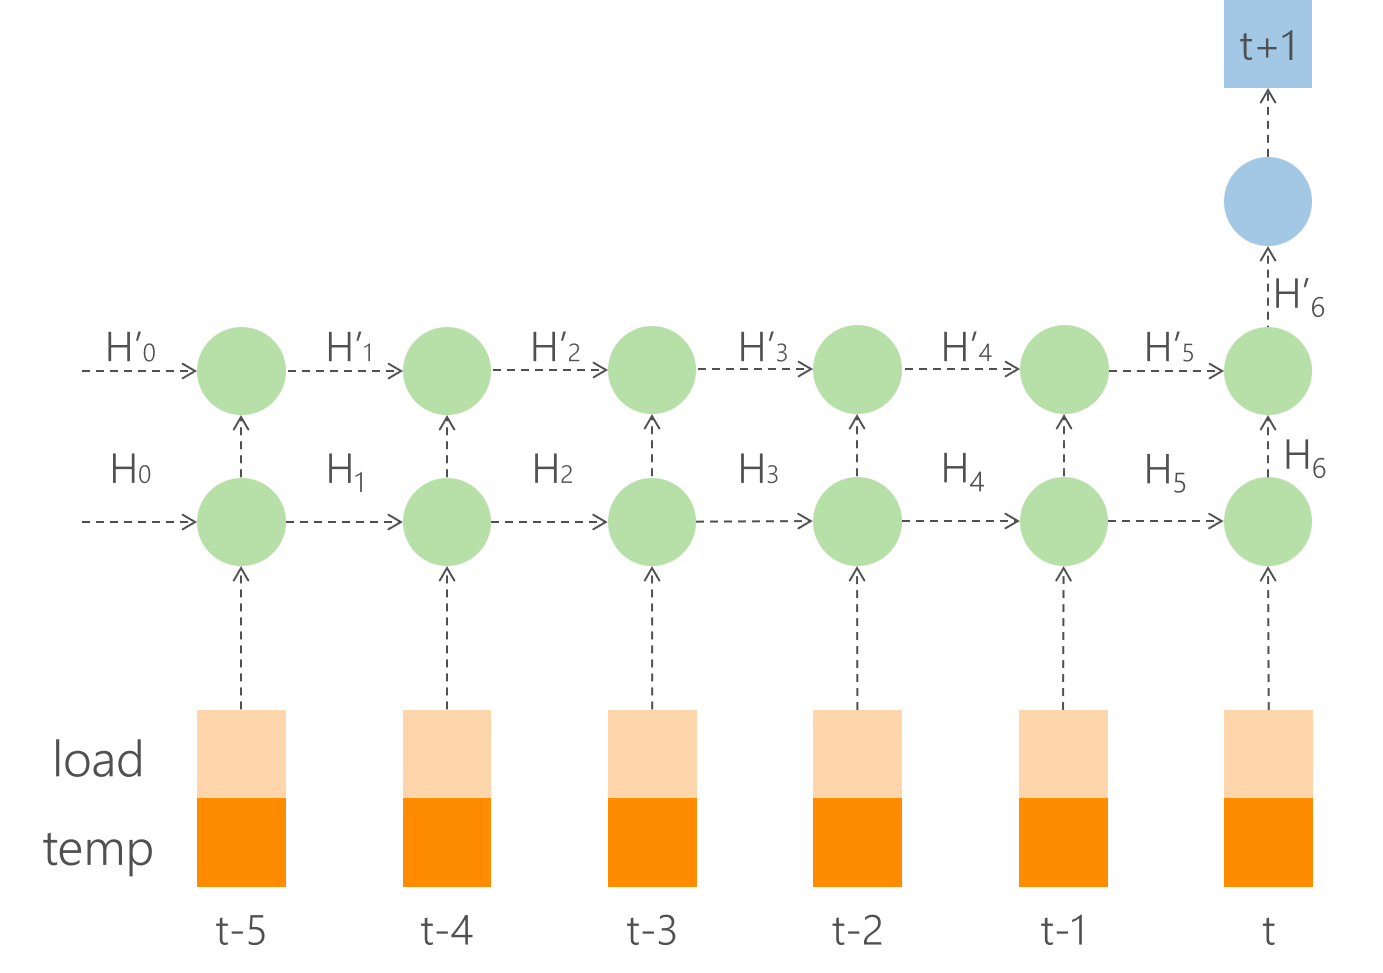

In [16]:
Image('./images/one_step_RNN_multivariate_mutilayer.png')

Once you done, run the rest of the notebook to check if your model works.

In [ ]:
model.compile(optimizer='RMSprop', loss='mse')
model.summary()

Specify the early stopping criteria. We **monitor** the validation loss (in this case the mean squared error) on the validation set after each training epoch. If the validation loss has not improved by **min_delta** after **patience** epochs, we stop the training.

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

## Evaluate the model

Create the test set

In [ ]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load', 'temp']]
test[['load', 'temp']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)
X_test = test_inputs['X']
y_test = test_inputs['target']

In [ ]:
predictions = model.predict(X_test)
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

In [ ]:
mape(eval_df['prediction'], eval_df['actual'])

In [ ]:
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()